In [3]:
import tensorflow as tf
print(tf.__version__)

2.5.0


In [17]:
import tensorflow_probability as tfp
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

#Define key parameters
batch_size = 50
image_height = 256
image_width = 256
channels = 1 # images are in grayscale
epochs = 25
latent_dims = 128
depth = 32


def create_image(data):
    #Creates a 3D image with extra grayscale channel added
    #4D tensor now
    image = tf.io.decode_png(data, channels=1)
    #normalise the image - float values between 0 and 1
    image = image / 255
    #resize image to 256 x 256
    return tf.image.resize(image, [image_height, image_width], antialias = True)

def get_image_from_file(path):
    #Extract file contents
    raw_data = tf.io.read_file(path)
    image = create_image(raw_data)
    return image

def set_dataset_parameters(dataset):
    # Make sure the dataset is in batches, well-shuffled and prefetches the information
    dataset = dataset.cache().shuffle(buffer_size=1000).batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)
    return dataset

def create_train_test_dataset(path_to_training_folder, path_to_test_folder):
    
    # Example path = 'H:\keras_png_slices_data\keras_png_slices_train\*'
    # Example training test_dir path = 'H:\keras_png_slices_data\keras_png_slices_test\*'
    
    # Create the training and testing datasets from the list of files
    training_files = tf.data.Dataset.list_files(path_to_training_folder, shuffle=False)
    test_files = tf.data.Dataset.list_files(path_to_test_folder, shuffle=False)

    #Retreive the size of each dataset
    num_train_images = training_files.cardinality().numpy()
    num_test_images = test_files.cardinality().numpy()
        
    # Shuffle the files
    training_files = training_files.shuffle(num_train_images, reshuffle_each_iteration=True)
    test_files = test_files.shuffle(num_test_images, reshuffle_each_iteration=True)

    # Map the filenames to images inside each dataset
    x_train = training_files.map(get_image_from_file, num_parallel_calls=tf.data.AUTOTUNE)
    x_test = test_files.map(get_image_from_file, num_parallel_calls=tf.data.AUTOTUNE)

    # Finalise data set configurations
    x_train = set_dataset_parameters(x_train)
    x_test2 = x_test.cache().prefetch(buffer_size=tf.data.AUTOTUNE).batch(544)
    x_test = set_dataset_parameters(x_test)   
    
    #Return the datasets
    return x_train, x_test, x_test2


training_ds, testing_ds_unbatched, testing_ds_batched = create_train_test_dataset('H:\keras_png_slices_data\keras_png_slices_train\*','H:\keras_png_slices_data\keras_png_slices_test\*')

In [2]:
#VQ-VAE parameters from the paper
beta = 0.25 #commitment loss weighting - based on the paper
K = 512 #Number of codebook vectors / embeddings number - using recommended value in the paper

# Vector Quantizer Layer
class Vector_Quantizer(tf.keras.layers.Layer):
    
    def __init__(self):
        super().__init__()
        #define the size of our embeddings - has same length as latent space vectors, and width as defined by K (hyperparameter)
        codebook_shape = (latent_dims, K)
        #create the embedding object - initialise uniformly
        initializer = tf.keras.initializers.RandomUniform(minval=0., maxval=1.)
        #Declare our embeddings as a tensorflow variable that will be learnt
        self._embeddings = tf.Variable(initializer(shape=codebook_shape, dtype='float32'), trainable = True)

    def quantize_vectors(self, vectors):
        #First need to calculate the distance between our input vectors and every vector in the codebook
        # Paper uses L2 norm: sqrt((x2-x1)^2 + (y2-y1)^2 +...)
        distances = tf.reduce_sum(vectors**2, axis=1, keepdims=True) - 2*tf.matmul(vectors, self._embeddings) + tf.reduce_sum(self._embeddings**2, axis=0, keepdims=True) 

        # Can now determine to which codebook vector our input vectors are closest to (minimum distance)
        indices = tf.argmin(distances, 1)
        
        #Do one-hot encoding so that only the closest codebook vector is mapped to a 1, all others to a 0
        one_hot_indices = tf.one_hot(indices, K)
        
        # Apply indices to the embeddings - now have quantized the vectors
        quantized_vectors = tf.matmul(one_hot_indices, self._embeddings, transpose_b=True)
        
        return indices, quantized_vectors

    def call(self, encoder_outputs):
        #Flatten all dimensions of the encoded vectors except the channels
        #Encoded vectors = (B,H,W,C) -> (B*H*W, C) i.e. flattened, each of which will be quantized independently
        encoded_vectors = tf.reshape(encoder_outputs, [-1, latent_dims])

        #Now can quantize each
        indices, quantized_vectors = self.quantize_vectors(encoded_vectors)
        
        # Reshape the flat vectors back into 2D for use in the convolutional decoder network
        reshaped_quantized_vectors = tf.reshape(quantized_vectors, tf.shape(encoder_outputs))
        
        #Do straight-through estimation so that back-propagation can occur
        # Going forward, output = encoder_output + quantized_vectors - encoder_output = quantized vectors (as desired)
        # Going backward, we copy the gradients at the decoder back to the encoder
        output = encoder_outputs + tf.stop_gradient(reshaped_quantized_vectors - encoder_outputs)
        return output, reshaped_quantized_vectors

In [3]:
# Define the encoder and decoder networks
def encoder_network():

    # Encoder network - takes input images and encodes them into z
    inputs = tf.keras.layers.Input(shape=(image_height, image_width, channels))
    
    # First downsample by half
    conv = tf.keras.layers.Conv2D(32, kernel_size=3, strides=2, activation='relu', padding = "same")(inputs)
    #Second downsample by half
    conv = tf.keras.layers.Conv2D(64, kernel_size=3, strides=2, activation='relu', padding = "same")(conv)
    #Third downsample by half
    #conv = tf.keras.layers.Conv2D(128, kernel_size=3, strides=2, activation='relu', padding = "same")(conv)
    
    #Final conv layer - image is now encoded into size of latent space
    output = tf.keras.layers.Conv2D(latent_dims, kernel_size = 1, padding = "same")(conv) #******************

    # Build the encoder
    final_network = tf.keras.Model(inputs, output, name="Encoder")

    return final_network

def decoder_network():
    # Takes the latent space and upsamples until original size is reached
    #256 -> downsampled twice = 256/4 = 64
    inputs = tf.keras.layers.Input(shape=(64,64,latent_dims))
    #input_shape = encoder().output.shape[1:]
    #inputs = tf.keras.layers.Input(shape=input_shape)
    
    # Now can upsample twice
    conv = tf.keras.layers.Conv2DTranspose(32, kernel_size=3, strides=2, padding='same', activation='relu')(inputs)
    conv = tf.keras.layers.Conv2DTranspose(16, kernel_size=3, strides=2, padding='same', activation='relu')(conv)
    
    #Output layer
    output = tf.keras.layers.Conv2D(1,kernel_size=[1,1], strides=1, activation='relu', padding = "same")(conv)
    
    #build the decoder
    final_network = tf.keras.Model(inputs, output, name="Decoder")
    return final_network


In [144]:
encoder = encoder_network()
print(encoder.summary())

Model: "Encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_70 (InputLayer)        [(None, 256, 256, 1)]     0         
_________________________________________________________________
conv2d_116 (Conv2D)          (None, 128, 128, 32)      320       
_________________________________________________________________
conv2d_117 (Conv2D)          (None, 64, 64, 64)        18496     
_________________________________________________________________
conv2d_118 (Conv2D)          (None, 64, 64, 128)       8320      
Total params: 27,136
Trainable params: 27,136
Non-trainable params: 0
_________________________________________________________________
None


In [145]:
decoder = decoder_network()
print(decoder.summary())

Model: "Decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_71 (InputLayer)        [(None, 64, 64, 128)]     0         
_________________________________________________________________
conv2d_transpose_60 (Conv2DT (None, 128, 128, 32)      36896     
_________________________________________________________________
conv2d_transpose_61 (Conv2DT (None, 256, 256, 16)      4624      
_________________________________________________________________
conv2d_119 (Conv2D)          (None, 256, 256, 1)       17        
Total params: 41,537
Trainable params: 41,537
Non-trainable params: 0
_________________________________________________________________
None


In [4]:
def reconstruction_loss(inputs, outputs):  
    #Calculate mse loss
    mse = tf.keras.losses.MeanSquaredError()
    recon_loss = mse(inputs, outputs)
    
    #Calculate ssim to use as part reconstruction loss - focusses on the brain rather than background
    ssim_loss = 1 - tf.image.ssim(inputs, outputs, max_val = 1)
    
    return recon_loss + ssim_loss

#Replace kl-divergence in traditional VAE with two terms as kl-divergence can't be minimized (is a constant)
def latent_loss(encoder_output, quantized_vectors):
    # latent commitment loss
    # beta*||z_e(x)-sg[e]|| i.e. freeze the codebook vectors/embeddings and push the encoded vectors towards codebook vectors
    mse1 = tf.keras.losses.MeanSquaredError()
    e_loss = beta * mse1(tf.stop_gradient(quantized_vectors), encoder_output)

    # latent codebook loss
    #||sg[z_e(x)]-e|| i.e. freeze the encoded vectors and push codebook vectors to encoded vectors
    mse2 = tf.keras.losses.MeanSquaredError()
    q_loss = mse2(quantized_vectors, tf.stop_gradient(encoder_output))
    
    return q_loss + e_loss

In [18]:
#Create overall vqvae model
def create_overall_vqvae(encoder_net, quantizer, decoder_net):
    inputs = tf.keras.Input(shape=(image_height, image_width, channels))
    encoder_outputs = encoder_net(inputs)
    quantized_latents, z1 = quantizer(encoder_outputs)
    reconstructions = decoder_net(quantized_latents)
    vq_vae_model_overall = tf.keras.Model(inputs, reconstructions, name="overall model")
    
    return vq_vae_model_overall


# create a training step
@tf.function
def training_step(images, optimizer, encoder, quantizer_layer, decoder, vq_vae_model_overall):
    with tf.GradientTape(persistent=True) as vae_tape:
        #Get the latent space
        z = encoder(images, training=True)
        #Get the quantized latent space
        z_quantized, z1 = quantizer_layer(z, training=True)
        #Get the reconstructions
        reconstructions = decoder(z_quantized, training=True)        

        #determine overall loss: recon_loss + latent_loss
        recon_loss = tf.reduce_mean(reconstruction_loss(images, reconstructions) )
        #recon_loss = reconstruction_loss(images, reconstructions)
        latent_loss1 = tf.reduce_mean(latent_loss(z, z1))
        
        total_loss = recon_loss + latent_loss1    
    
    gradients = vae_tape.gradient(total_loss, vq_vae_model_overall.trainable_variables)
    
    #apply the gradients to the optimizer
    optimizer.apply_gradients(zip(gradients, vq_vae_model_overall.trainable_variables))
    
    return recon_loss, latent_loss1, total_loss

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25


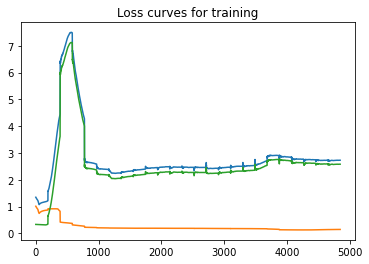

In [19]:
#Create the encoder and decoder components of VQ-VAE Model
encoder = encoder_network()
decoder = decoder_network()
quantizer_layer = Vector_Quantizer()
optimizer = tf.keras.optimizers.Adam(1e-4)

vq_vae_overall = create_overall_vqvae(encoder, quantizer_layer, decoder)

# Training
def train(encoder_net, decoder_net, quantizer_net, opt, vq_model):
    recon_loss_list = []
    latent_loss_list = []

    losses = []
    for epoch in range(1, epochs+1):
        print(epoch)
        loss = -1
        batch_losses = 0

        batch_losses_recon = 0
        batch_losses_latent = 0

        count = 0

        for image_batch in training_ds:

            recon_loss, latent_loss_results, total_loss = training_step(image_batch, opt, encoder_net, quantizer_net, decoder_net, vq_model)

            batch_losses += total_loss
            batch_losses_recon += recon_loss
            batch_losses_latent += latent_loss_results
            count += 1 

            losses.append(batch_losses/count)
            recon_loss_list.append(batch_losses_recon/count)
            latent_loss_list.append(batch_losses_latent/count)
    
    
    # Plot the loss curves
    plt.title('Loss curves for training')
    plt.plot(losses)
    plt.plot(recon_loss_list)
    plt.plot(latent_loss_list)

    plt.show()
    
    #return encoder, decoder, quantizer_layer, vq_vae_overall

train(encoder, decoder, quantizer_layer, optimizer, vq_vae_overall)

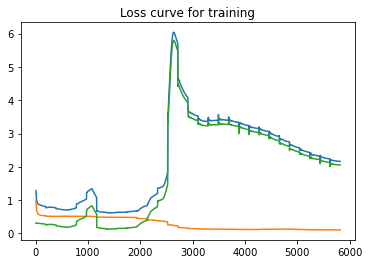

In [158]:
plt.title('Loss curve for training')
plt.plot(losses)
plt.plot(recon_loss_list)
plt.plot(latent_loss_list)

plt.show()

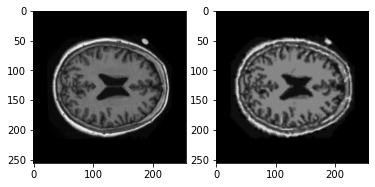

[0.9006816]


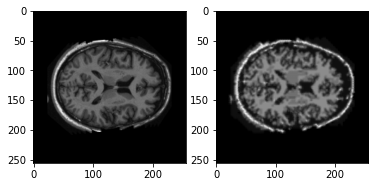

[0.8861061]


In [159]:
test_batch = testing_ds_batched.take(1)
train_batch = training_ds.take(1)
test_image = 0
train_image = 0
for element in test_batch:
    for image in element:
        test_image = image[tf.newaxis, :]
        break
    break

for element in train_batch:
    for image in element:
        train_image = image[tf.newaxis, :]
        break
    break

z = encoder(test_image, training=False)
#Get the quantized latent space
z_quantized, z1 = quantizer_layer(z, training=False)
#Get the reconstructions
result = decoder(z_quantized, training=False)


#Plot the resulting image compared to original
plt.subplot(1,2,1)
plt.imshow(test_image[0, :, :, 0], cmap='gray')

plt.subplot(1,2,2)
plt.imshow(result[0, :, :, 0], cmap='gray')
plt.show()

ssim = tf.image.ssim(test_image, result, max_val = 1)
print(ssim.numpy())


#Check a reconstruction of a training image
z = encoder(train_image, training=False)
#Get the quantized latent space
z_quantized, z1 = quantizer_layer(z, training=False)
#Get the reconstructions
result = decoder(z_quantized, training=False)

#Plot the resulting image compared to original
plt.subplot(1,2,1)
plt.imshow(train_image[0, :, :, 0], cmap='gray')
plt.subplot(1,2,2)
plt.imshow(result[0, :, :, 0], cmap='gray')
plt.show()


ssim = tf.image.ssim(train_image, result, max_val = 1)
print(ssim.numpy())


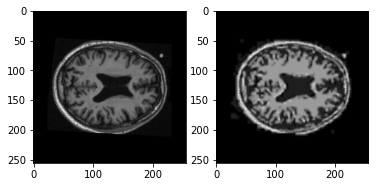

[0.81307614]


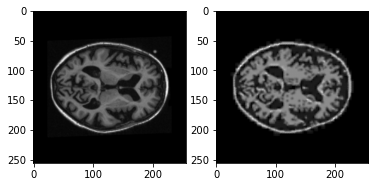

[0.7893175]


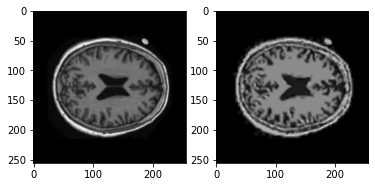

[0.84338415]


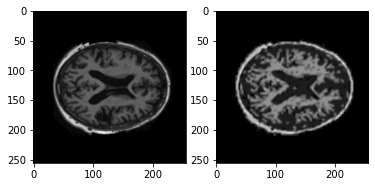

[0.85716134]


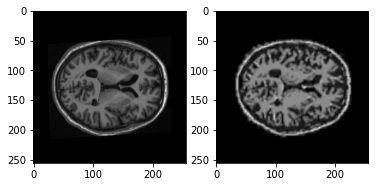

[0.7985995]


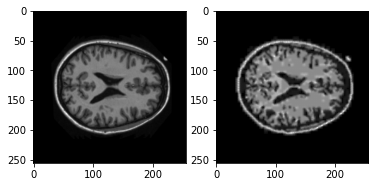

[0.84868276]
0.82379925


In [20]:
# Calculate SSIM for the entire testing dataset
def calculate_ssims(vq_vae_model_overall):
    ssim_scores_testing = []

    for batch in testing_ds_batched:
        for n,image in enumerate(batch):
            test_image = image[tf.newaxis, :]

            result = vq_vae_model_overall(test_image, training=False)

            #z = encoder(test_image, training=False)
            #Get the quantized latent space
            #z_quantized, z1 = quantizer_layer(z, training=False)
            #Get the reconstructions
            #result = decoder(z_quantized, training=False)

            ssim = tf.image.ssim(test_image, result, max_val = 1)
            ssim_scores_testing.append(ssim)

            # Show an example every 100th image
            if n % 100 == 0:
                #Plot the resulting image compared to original
                plt.subplot(1,2,1)
                plt.imshow(test_image[0, :, :, 0], cmap='gray')

                plt.subplot(1,2,2)
                plt.imshow(result[0, :, :, 0], cmap='gray')
                plt.show()
                print(ssim.numpy())

    #Display the mean ssim
    ssim_score = (tf.reduce_mean(ssim_scores_testing)).numpy()
    return ssim_score

ssim_score = calculate_ssims(vq_vae_overall)
print(ssim_score)


In [27]:
# PixelCNN
num_residual_blocks = 2
num_pixelcnn_layers = 2

pixelcnn_input_shape = (64,64)


# The first layer is the PixelCNN layer. This layer simply
# builds on the 2D convolutional layer, but includes masking.
class PixelConvLayer(tf.keras.layers.Layer):
    def __init__(self, mask_type, **kwargs):
        super(PixelConvLayer, self).__init__()
        self.mask_type = mask_type
        self.conv = tf.keras.layers.Conv2D(**kwargs)

    def build(self, input_shape):
        # Build the conv2d layer to initialize kernel variables
        self.conv.build(input_shape)
        # Use the initialized kernel to create the mask
        kernel_shape = self.conv.kernel.get_shape()
        self.mask = np.zeros(shape=kernel_shape)
        self.mask[: kernel_shape[0] // 2, ...] = 1.0
        self.mask[kernel_shape[0] // 2, : kernel_shape[1] // 2, ...] = 1.0
        if self.mask_type == "B":
            self.mask[kernel_shape[0] // 2, kernel_shape[1] // 2, ...] = 1.0

    def call(self, inputs):
        self.conv.kernel.assign(self.conv.kernel * self.mask)
        return self.conv(inputs)


# Next, we build our residual block layer.
# This is just a normal residual block, but based on the PixelConvLayer.
class ResidualBlock(tf.keras.layers.Layer):
    def __init__(self, filters, **kwargs):
        super(ResidualBlock, self).__init__(**kwargs)
        self.conv1 = tf.keras.layers.Conv2D(
            filters=filters, kernel_size=1, activation="relu"
        )
        self.pixel_conv = PixelConvLayer(
            mask_type="B",
            filters=filters // 2,
            kernel_size=3,
            activation="relu",
            padding="same",
        )
        self.conv2 = tf.keras.layers.Conv2D(
            filters=filters, kernel_size=1, activation="relu"
        )

    def call(self, inputs):
        x = self.conv1(inputs)
        x = self.pixel_conv(x)
        x = self.conv2(x)
        return tf.keras.layers.add([inputs, x])


def create_pixelCNN():
    pixelcnn_inputs = tf.keras.Input(shape=pixelcnn_input_shape, dtype=tf.int32)
    one_hot_encoding = tf.one_hot(pixelcnn_inputs, K)
    x = PixelConvLayer(
        mask_type="A", filters=128, kernel_size=32, activation="relu", padding="same" #kernel_size = 7!
    )(one_hot_encoding)

    for _ in range(num_residual_blocks):
        x = ResidualBlock(filters=128)(x)

    for _ in range(num_pixelcnn_layers):
        x = PixelConvLayer(
            mask_type="B",
            filters=128,
            kernel_size=1,
            strides=1,
            activation="relu",
            padding="valid",
        )(x)

    out = tf.keras.layers.Conv2D(
        filters=K, kernel_size=1, strides=1, padding="valid"
    )(x)

    pixel_cnn = tf.keras.Model(pixelcnn_inputs, out, name="pixel_cnn")
    return pixel_cnn

pixel_cnn = create_pixelCNN()
pixel_cnn.summary()

Model: "pixel_cnn"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_17 (InputLayer)        [(None, 64, 64)]          0         
_________________________________________________________________
tf.one_hot_1 (TFOpLambda)    (None, 64, 64, 512)       0         
_________________________________________________________________
pixel_conv_layer_5 (PixelCon (None, 64, 64, 128)       67108992  
_________________________________________________________________
residual_block_2 (ResidualBl (None, 64, 64, 128)       98624     
_________________________________________________________________
residual_block_3 (ResidualBl (None, 64, 64, 128)       98624     
_________________________________________________________________
pixel_conv_layer_8 (PixelCon (None, 64, 64, 128)       16512     
_________________________________________________________________
pixel_conv_layer_9 (PixelCon (None, 64, 64, 128)       16

In [29]:
#PixelCNN Training

codebook_indices_vector = []

def get_codebook_indices(codebook_indices_vector):
    for n,batch in enumerate(training_ds):
        # Generate the codebook indices.
        encoded_outputs = encoder.predict(batch)
        flat_enc_outputs = encoded_outputs.reshape(-1, encoded_outputs.shape[-1])
        codebook_indices, vectors = quantizer_layer.quantize_vectors(flat_enc_outputs)

        codebook_indices2 = codebook_indices.numpy().reshape(encoded_outputs.shape[:-1])

        if n == 0:
            codebook_indices_vector = codebook_indices2
        else:
            codebook_indices_vector = tf.concat([codebook_indices_vector, codebook_indices2], 0)
        #print(codebook_indices_vector.shape)
    
    return codebook_indices_vector
    
codebook_indices_vector = get_codebook_indices(codebook_indices_vector)
print(f"Shape of the training data for PixelCNN: {codebook_indices_vector.shape}")

pixel_cnn.compile(
    optimizer=tf.keras.optimizers.Adam(3e-4),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"],
)
pixel_cnn.fit(
    x=codebook_indices_vector,
    y=codebook_indices_vector,
    batch_size=128,
    epochs=30,
    validation_split=0.1,
)

Shape of the training data for PixelCNN: (9664, 64, 64)
Epoch 1/30


ResourceExhaustedError:  OOM when allocating tensor with shape[128,512,64,64] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[node pixel_cnn/conv2d_39/Conv2D (defined at <ipython-input-29-ba912c17d305>:30) ]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_911836]

Errors may have originated from an input operation.
Input Source operations connected to node pixel_cnn/conv2d_39/Conv2D:
 pixel_cnn/pixel_conv_layer_9/conv2d_38/Relu (defined at <ipython-input-21-9be6e58eb5fb>:29)

Function call stack:
train_function


In [ ]:
#sample distinct codes from the pixelcnn output and pass them to the vqvae decoder to generate novel images
# Create a mini sampler model.
inputs = tf.keras.layers.Input(shape=pixel_cnn.input_shape[1:])
x = pixel_cnn(inputs, training=False)
dist = tfp.distributions.Categorical(logits=x)
sampled = dist.sample()
sampler = tf.keras.Model(inputs, sampled)


# Create an empty array of priors.
batch = 10
priors = tf.zeros(shape=(batch,) + (pixel_cnn.input_shape)[1:])
batch, rows, cols = priors.shape

# Iterate over the priors because generation has to be done sequentially pixel by pixel.
for row in range(rows):
    for col in range(cols):
        # Feed the whole array and retrieving the pixel value probabilities for the next
        # pixel.
        probs = sampler.predict(priors)
        # Use the probabilities to pick pixel values and append the values to the priors.
        priors[:, row, col] = probs[:, row, col]

print(f"Prior shape: {priors.shape}")

In [ ]:
# Perform an embedding lookup.
pretrained_embeddings = quantizer._embeddings
priors_ohe = tf.one_hot(priors.astype("int32"), K).numpy()
quantized = tf.matmul(
    priors_ohe.astype("float32"), pretrained_embeddings, transpose_b=True
)
quantized = tf.reshape(quantized, (-1, *(encoded_outputs.shape[1:])))

# Generate novel images.
generated_samples = decoder.predict(quantized)

for i in range(batch):
    plt.subplot(1, 2, 1)
    plt.imshow(priors[i])
    plt.title("Code")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(generated_samples[i].squeeze() + 0.5)
    plt.title("Generated Sample")
    plt.axis("off")
    plt.show()